# Gaussian Mixture Model
<b>Zhiling Tan</b>


This notebook includes two parts:
1. The solution to the assignment based on my understanding.
2. An implementation of Gaussian Mixture Models in Pytorch. 


## 1. pytorch auto-grad GMM
#### Assignment:
Can you create a Gaussian Mixture Model (GMM) and use it to generate samples as tensors that are linked to the parameters of the GMM? That is the gradient of an objective function, which is calculated using the samples, can be propagated to the parameters of the GMM.

#### To solve this problem:

(1). generated means and covariance matrix(contains correlation coefficients) randomly.

(2). create a GMM using <b>MultivariateNormal</b> and <b>MixtureSameFamily</b> class from <b>torch.distributions</b> package, based on the means and covariance generated in step1.

(3). set samples' attribute <b>.requires_grad</b> as <b>True</b> and define an objective function. 

(4) call <b>backward( )</b> & calculate the gradient.

<b>PS</b>: I don't understand what the objective function of GMM should be. (EM algorithm don't require obejective function) So I assume the objective function as <i>mean( )</i> for the test.


#### reference:

https://pytorch.org/docs/stable/distributions.html

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [11]:
import torch
import torch.distributions as D
import numpy as np

"""
GMM with random mu & covariance & random pi allowing gradient
args:
    n_components:   number of mixed components
    n_attributes:   number of mixed attributes
paramteters:
    mix:            distribution of mixed components  
                    class: Categorical - a categorical distribution parameterized by probs
                    shape: tensor(n_components)
    mu:             mean of attributes of each components
                    shape: tensor(n_components, n_attributes)
    sigma:          covariance matrix of each components
                    shape: tensor(n_components, n_attributes, n_attributes)
"""

dtype = torch.float
device = torch.device("cpu")

n_components = 3
n_attributes = 2


# components distribution
mix = D.categorical.Categorical(torch.abs(torch.rand(n_components))) 

# - random means
mu = torch.randn(n_components, n_attributes)

# - random covariance matrix
def randn_sigma(n_components, n_attributes):
    x = torch.rand(n_components, n_attributes, n_attributes)
    x_t = torch.transpose(x, 1, 2)
    sigma = torch.empty(n_components, n_attributes, n_attributes)
    for i in range(0, n_components):
        sigma[i] = torch.mm(x[i], x_t[i])
    return(sigma)
sigma = randn_sigma(n_components, n_attributes)


# component distributions
comp = D.multivariate_normal.MultivariateNormal(mu, sigma) 
# mixture distributions
gmm = D.mixture_same_family.MixtureSameFamily(mix, comp)


# generate 200 sample from GMM model & require dradient
y= gmm.sample([200])
y.requires_grad_(True)


# test gradient: 
# assume obj = mean(y); that is obj = [1/(n_attributes * dim)] * y 
# derivate = 1/n_attributes 
obj =  y.mean()
obj.backward()
print(y.grad[1:10,])

tensor([[0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025],
        [0.0025, 0.0025]])


## 2.  GMM implementation

### Import packages

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import multivariate_normal
import math
from math import pi
import matplotlib.pyplot as plt

### Define GMM model:
For simplicity, I assume that all attributes（dimensions）are independent of each other（no correlation coefficients).

#### reference:
https://github.com/ldeecke/gmm-torch/blob/master/gmm.py

https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf


In [3]:
class GMM(torch.nn.Module):
    def __init__(self, n_features, n_dimentions, mu_init=None, var_init=None, epsilon=1e-6):
        """
        Gaussian Mixuture Model:
        mixture model of n_features multivariate normal distributions
        args:
            x:              [optional] input sample data 
                            shape: tensor(n_samles, n_dimentions) 
            n_features:   number of mixiture distributions (features/clusters).
            n_dimentions:   number of attributes (dimentions).
            
            epsolion:       float, for avoiding divide by zero
        parameters:
            mu:             The mean of each mixture component.
                            shape: tensor(1, n_features, n_dimentions)
            var:          the covariance of each mixture component.
                            shape: tensor(1, n_features, n_dimentions, n_dimentions)
        """
        
        # model parameters
        super(GMM, self).__init__()
        
        self.n_features = n_features
        self.n_dimentions = n_dimentions
        self.mu = mu
        self.var = var
        self.logvar = self.var.log()
        self.eps=epsilon
        
        self.pi = torch.empty(1,n_features,1)
        self.pi.data = (torch.ones(1,n_features,1))/n_features #equally likely mixture features
        
    
    def _log_gaussian(self, x, mu=0, logvar=0.):
        """
        Returns the component-wise density of x under the gaussian parameterised by `mean` and `logvar`
        """
        log_norm_constant = -0.5 * np.log(2 * np.pi)
        if type(logvar) == 'float':
            logvar = x.new(1).fill_(logvar)
        a = (x - mu) ** 2
        log_p = -0.5 * (logvar + a / logvar.exp())
        log_p = log_p + log_norm_constant

        return log_p
    
    def _log_likelihoods(self, x, logvar):
        # (K, samples, features)
        mu = self.mu
        log_likelihood = self._log_gaussian(
            x[None, :, :], #(1, samples, features)
            mu[:, None, :], #(K, 1, features)
            logvar[:, None, :]#(K, 1, features)
        )
        log_likelihood = log_likelihood.sum(-1)
        
        return log_likelihood
    
    def _cal_posteriors(self, log_likelihood):
        posteriors = log_likelihood 
        posteriors = posteriors - torch.logsumexp(posteriors, dim=0, keepdim=True)
        return posteriors
    
    def _updata_param(self, x, log_posteriors, eps=1e-6):
        posteriors = log_posteriors.exp()

        K = posteriors.size(0)
        N_k = torch.sum(posteriors, dim=1) # (K)
        N_k = N_k.view(K, 1, 1)
        
        print("num of point that is assigned to each gaussian: ")
        print(N_k)

        
        # (K, 1, examples) @ (1, examples, features) -> (K, 1, features)
        mu = posteriors[:, None] @ x[None,]
        mu = mu / (N_k + eps)

      
        y = x.unsqueeze(0) - mu
        var = posteriors[:, None] @ (y * y) # (K, 1, features)
        var = var / (N_k + eps)
        logvar = torch.clamp(var, min=1e-6).log()

        # recompute the mixing probabilities
        pi = N_k / N_k.sum()

        return mu.squeeze(1), logvar.squeeze(1), pi.squeeze()
        
    
    def fitGMM(self, x, n_iter=50, err=1e-8):

        pre_cost = float('inf')
        for i in range(n_iter):
            log_likelihoods = self._log_likelihoods(x, self.logvar)
            log_posteriors = self._cal_posteriors(log_likelihoods)
            
            cost = log_likelihoods.mean()
            diff = pre_cost - cost
            if torch.abs(diff).item() < err:
                print("fit done!")
                break
            pre_cost = cost
            
            self.mu, self.logvar, self.pi = self._updata_param(x, log_posteriors)
            print(i," iter:")
            print("mu: ", self.mu)
            print("pi: ", self.pi)
            print("logvar: ", self.logvar)
            print("----------------------------------")
      

## Initialze paramaters 
Improvement method: using the results of K-Means as an initial value for $\mu_k$

(maybe implement it later? and compara which one can achieve better results)

In [4]:
def initialize(data, features, var=1):
    """
    Randomly initialize the parameters for `k` gaussians.
    """
    # choose k points from data to initialize means
    m = data.size(0)
    i = torch.from_numpy(np.random.choice(m, features, replace=False))
    mu = data[i]

    # uniform sampling for means and variances
    var = torch.Tensor(features, dim).fill_(var)
    
    # equally likely mixture components
    pi = torch.empty(features).fill_(1. / features)

    return mu, var, pi

### Generate samples from random GMM
#### Reference:
https://github.com/aakhundov/tf-example-models/blob/master/models/tf_kmeans.py

In [5]:
DIMENSIONS = 2
CLUSTERS = 3
DATA_POINTS = 1000
def generate_gmm_data(points, components, dimensions):
    """Generates synthetic data of a given size from a random GMM"""
    np.random.seed(219)

    c_means = np.random.normal(size=[components, dimensions]) * 10
    c_variances = np.abs(np.random.normal(size=[components, dimensions]))
    c_weights = np.abs(np.random.normal(size=[components]))
    c_weights /= np.sum(c_weights)

    result = np.zeros((points, 1, dimensions), dtype=np.float32)

    for i in range(points):
        comp = np.random.choice(np.array(range(CLUSTERS)), p=c_weights)
        result[i] = np.random.multivariate_normal(
            c_means[comp], np.diag(c_variances[comp])
        )

    np.random.seed()

    return result, c_means, c_variances, c_weights

In [6]:
sample, true_means, true_variances, true_weights = generate_gmm_data(DATA_POINTS, CLUSTERS, DIMENSIONS)
data = torch.tensor(sample)
data = data.squeeze(1)
data.requires_grad_(True)  # auto-grad
print(data)
print("---------------------------------")
print("mean: ", true_means)
print("---------------------------------")
print("pi: ", true_weights)
print("---------------------------------")
print("log_var:", np.log(true_variances))

tensor([[ 2.5863,  4.9325],
        [10.7978, -2.8794],
        [ 2.0587,  6.3497],
        ...,
        [10.0919, -1.8412],
        [ 3.1869,  5.7168],
        [ 2.6392,  3.6349]], requires_grad=True)
---------------------------------
mean:  [[-5.71369614 -7.99577437]
 [ 2.59275506  5.30706069]
 [10.79572809 -2.44346959]]
---------------------------------
pi:  [0.11936217 0.65504692 0.22559091]
---------------------------------
log_var: [[ 0.41284553 -1.40222891]
 [-0.67235534 -0.37121755]
 [-1.72339317 -0.24756056]]


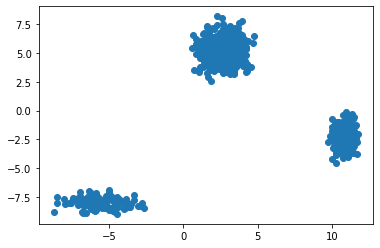

In [7]:
def plot_2d_sample(sample):
    sample_np = sample.detach().numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    plt.scatter(x, y)
    
plot_2d_sample(data)

## Fit the model using the samples

In [8]:
features = 3
dim = 2
mu, var, pi = initialize(data, features, var=1)
model = GMM(features, dim, mu, var)
model.fitGMM(data)

num of point that is assigned to each gaussian: 
tensor([[[353.2728]],

        [[408.3874]],

        [[238.3398]]], grad_fn=<ViewBackward>)
0  iter:
mu:  tensor([[ 2.7800,  5.3981],
        [ 6.8489,  1.2731],
        [-1.7646, -1.6247]], grad_fn=<SqueezeBackward1>)
pi:  tensor([0.3533, 0.4084, 0.2383], grad_fn=<SqueezeBackward0>)
logvar:  tensor([[0.2715, 0.3035],
        [2.8221, 2.6607],
        [2.8067, 3.7475]], grad_fn=<SqueezeBackward1>)
----------------------------------
num of point that is assigned to each gaussian: 
tensor([[[613.5221]],

        [[244.0715]],

        [[142.4064]]], grad_fn=<ViewBackward>)
1  iter:
mu:  tensor([[ 2.6010,  5.2944],
        [ 9.7088, -1.3567],
        [-4.2618, -6.1612]], grad_fn=<SqueezeBackward1>)
pi:  tensor([0.6135, 0.2441, 0.1424], grad_fn=<SqueezeBackward0>)
logvar:  tensor([[-0.6749, -0.3807],
        [ 2.0885,  1.9243],
        [ 2.5788,  3.0038]], grad_fn=<SqueezeBackward1>)
----------------------------------
num of point that is a

In [12]:
# test gradient: 
# assume obj = mean(y); that is obj = [1/(n_dim * n_samples)] * y 
# derivate = 1/(1000 * 2) -->(0.0005)
obj =  data.mean()
obj.backward()
print(data.grad[1:10,])

tensor([[0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010],
        [0.0010, 0.0010]])
